# Process Mini-Secchi disk data for SOCON

The purpose of this notebook is to extact Mini-Secchi disk data from the SOCON project via the Monocle Data dashboard (https://rsg.pml.ac.uk/dashboards/d/P0tWxs97k/mini-secchi-disk?orgId=1&refresh=15m) collected using the mini-Secchi disk app 

Once data is extracted it is quality controlled using a series of steps and a comma seperated file is produced. Plots and then produced of the geographical and statistical distribution of the data. 

Coded by Bob Brewin, University of Exeter

## Step 1: Import packages needed to run the notebook and define functions

In [1]:
##Packages needed for notebook
import monda
import contextily as ctx
import geopandas as gpd
import datetime as dt
import numpy as np
import matplotlib as mpl
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
import matplotlib.ticker as mticker

##Subpackages needed
from monda.minisecchi import access
from matplotlib import pyplot as plt
from datetime import datetime
from shapely.geometry import Point
from pyproj import Transformer
from scipy.stats import norm

# Function to convert Web Mercator coordinates to latitude/longitude
def merc_to_lonlat(x, pos):
    lon, lat = transformer_to_lonlat.transform(x, 0)  # Only convert X (Longitude)
    return f"{lon:.3f}°"
def merc_to_latlon(y, pos):
    lon, lat = transformer_to_lonlat.transform(0, y)  # Only convert Y (Latitude)
    return f"{lat:.3f}°"

## Step 2: Extract SOCON data from Monocle App using Geoserver 

In [2]:
##Define a start and end date (note geolocation was fixed in October 2023 but we are start from projecy KO)
##start_date = dt.datetime(2023,10,1,0,0,0) ##geolocation was fixed in October 2023
start_date = dt.datetime(2022,8,1,0,0,0) ## SOCON Start date
end_date = dt.datetime(2025,8,31,0,0,0) ## SOCON End date

##Define Geoserver layer
geoserver_layer = 'rsg:minisecchi_public_view'

##Define geographical box
##ALL
bbox = None  # alternatively supply a tuple of (corner1 lat, corner1 lon, corner2 lat, corner2 lon)
# ##SOCON US data
bbox = (20, -40, 60, -130)

##Extract data from Geoserver
response = access.get_wfs(count=10000, timewindow=(start_date, end_date), layer=geoserver_layer, bbox=bbox)
data     = response['result']

##Print all the data keys to see what data is available
print(data[0].keys())

##Pull data from response 
sample_uuid     = np.array([response['result'][i]['sample_uuid'] for i in range(len(response['result']))])
platform_id     = np.array([response['result'][i]['platform_id'] for i in range(len(response['result']))])
platform_uuid   = np.array([response['result'][i]['platform_uuid'] for i in range(len(response['result']))])
time            = np.array([response['result'][i]['time'] for i in range(len(response['result']))])
latitude        = np.array([response['result'][i]['latitude'] for i in range(len(response['result']))])
longitude       = np.array([response['result'][i]['longitude'] for i in range(len(response['result']))])
z_secchi_cm     = np.array([response['result'][i]['z_secchi_cm'] for i in range(len(response['result']))])
swversion       = np.array([response['result'][i]['swversion_number'] for i in range(len(response['result']))])
l_water_cm      = np.array([response['result'][i]['l_water_cm'] for i in range(len(response['result']))])
l_vis_cm        = np.array([response['result'][i]['l_vis_cm'] for i in range(len(response['result']))])
fu_halfz        = np.array([response['result'][i]['fu_halfz'] for i in range(len(response['result']))])
fu_surface      = np.array([response['result'][i]['fu_surface'] for i in range(len(response['result']))])
phvalue         = np.array([response['result'][i]['phvalue'] for i in range(len(response['result']))])
bottom_visible  = np.array([response['result'][i]['bottom_visible'] for i in range(len(response['result']))])
end_of_tape     = np.array([response['result'][i]['end_of_tape'] for i in range(len(response['result']))])
angle_estimated = np.array([response['result'][i]['angle_estimated'] for i in range(len(response['result']))])
license         = np.array([response['result'][i]['license'] for i in range(len(response['result']))])
license_ref     = np.array([response['result'][i]['license_reference'] for i in range(len(response['result']))])
received_time   = np.array([response['result'][i]['received_time'] for i in range(len(response['result']))])
ingested_time   = np.array([response['result'][i]['ingested_time'] for i in range(len(response['result']))])
updated_time    = np.array([response['result'][i]['updated_time'] for i in range(len(response['result']))])
##Uncorrected lat and lon (Stefan adjusted Scotland latitude and longitude manually)
lon             = np.array([response['result'][i]['lon'] for i in range(len(response['result']))])
lat             = np.array([response['result'][i]['lat'] for i in range(len(response['result']))])

2025-02-03 13:40:07,442 | secchi-downloader | INFO | Pre-paging request: https://rsg.pml.ac.uk/geoserver/rsg/wfs?request=GetFeature&version=2.0.0&service=WFS&typeName=rsg:minisecchi_public_view&count=10000&srsname=EPSG:4326&outputFormat=json&sortBy=time+A&CQL_FILTER=time%20between%202022-08-01T00%3A00%3A00Z%20AND%202025-08-31T00%3A00%3A00Z%20AND%20BBOX%28location%2C%2020%2C-40%2C60%2C-130%29&resultType=hits
2025-02-03 13:40:07,529 | secchi-downloader | INFO | 571 features matched
2025-02-03 13:40:07,763 | secchi-downloader | INFO | Page 0, starting at count 0: 571 features
dict_keys(['sample_uuid', 'platform_id', 'platform_uuid', 'time', 'latitude', 'longitude', 'z_secchi_cm', 'swversion_number', 'l_water_cm', 'l_vis_cm', 'fu_halfz', 'fu_surface', 'phvalue', 'bottom_visible', 'end_of_tape', 'angle_estimated', 'license', 'license_reference', 'received_time', 'ingested_time', 'updated_time', 'lon', 'lat'])


## Step 3: Basic Quality Control of SOCON data

In [3]:
## Quality Control
for l in range(9):
    if l == 0:
        ASD = np.where(lon <= 180) ## Geo quality control (must be on planet)
    if l == 1:
        ASD = np.where(lon >= -180) ## Geo quality control (must be on planet)
    if l == 2:
        ASD = np.where(lat <= 90) ## Geo quality control (must be on planet)
    if l == 3: 
        ASD = np.where(lat >= -90) ## Geo quality control (must be on planet)
    if l == 4:
        ASD = np.where(bottom_visible != True) ## Bottom Visible
    if l == 5:
        ASD = np.where(end_of_tape != True) ## End of tape
    if l == 6:
        ASD = np.where([(x is None or x <= 15) for x in angle_estimated])[0]  # remove angles > 15 degrees
    if l == 7:
        ASD  = np.where([(x is not None and 0 < x <= 2000) for x in z_secchi_cm])[0] # QC Secchi between 0 and 20m
    if l == 8:
        ASD  = np.where([(x is not None and 1 <= x <= 21) for x in fu_halfz])[0] # QC FU between 1 and 21
    ## Quality control
    sample_uuid     = sample_uuid[ASD]
    platform_id     = platform_id[ASD]
    platform_uuid   = platform_uuid[ASD]
    time            = time[ASD]
    latitude        = latitude[ASD]
    longitude       = longitude[ASD]
    z_secchi_cm     = z_secchi_cm[ASD]
    swversion       = swversion[ASD]
    l_water_cm      = l_water_cm[ASD]
    l_vis_cm        = l_vis_cm[ASD]
    fu_halfz        = fu_halfz[ASD]
    fu_surface      = fu_surface[ASD]
    phvalue         = phvalue[ASD]
    bottom_visible  = bottom_visible[ASD]
    end_of_tape     = end_of_tape[ASD]
    angle_estimated = angle_estimated[ASD]
    license         = license[ASD]
    license_ref     = license_ref[ASD]
    received_time   = received_time[ASD]
    ingested_time   = ingested_time[ASD]
    updated_time    = updated_time[ASD]
    lon             = lon[ASD]
    lat             = lat[ASD]    
    print(len(z_secchi_cm))

571
571
571
571
500
500
475
453
430


## STEP 4: Create a CSV file of the data

In [4]:
## Convert Time
Time   = time.astype('datetime64') ## Convert Monocle to datetime

## Rename Lat and lon
Lat    = latitude
Lon    = longitude

## Rename Secchi and FU
Secchi = z_secchi_cm/100. ## Comvert to m
FU     = fu_halfz

## Create a Pandas DataFrame
df = pd.DataFrame({
    'Time-(UTC)': Time,
    'Latitude-(degN)': Lat,
    'Longitude-(degE)': Lon,
    'Secchi-depth-(m)': Secchi,
    'FU-(disk-1/2-Secchi-depth)': FU
})

# Save the DataFrame to a CSV file
df.to_csv('Mini_Secchi_MONOCLE_SOCON.csv', index=False)  # index=False to avoid writing the row numbers

## STEP 5: Plot US map of the data

2025-02-03 13:40:08,387 | fiona._env | ERROR | PROJ: proj_identify: /Users/bobbrewin/opt/miniconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


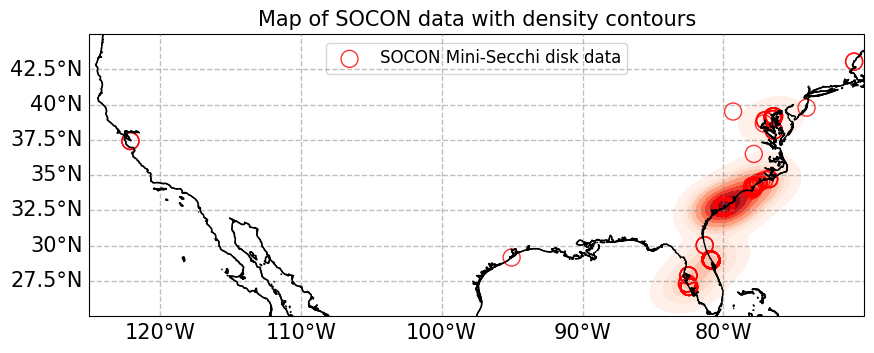

In [5]:
#Box around US
Max_lon    = -70
Min_lon    = -125
Max_lat    = 45
Min_lat    = 25

#Create Figure
fig, (ax1) = plt.subplots(1,1, figsize=(10,5), \
                gridspec_kw={'hspace': 0.05}, subplot_kw={'projection': ccrs.PlateCarree()})
fig.patch.set_facecolor('White')
ax1.coastlines()
ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='k', facecolor='none',zorder=14))
ax1.set_xlim([Min_lon, Max_lon])
ax1.set_ylim([Min_lat, Max_lat])
ax1.set_title('Map of SOCON data with density contours', fontsize = 15)

##Plot latitude and longitude
im1 = ax1.scatter(Lon, Lat,  transform=ccrs.PlateCarree(), \
            marker = 'o', s = 150, alpha=0.8, zorder=12, label = 'SOCON Mini-Secchi disk data', facecolors='none', edgecolors='r') 
##Plot density contours
sns.kdeplot(
    x=Lon, y=Lat,
    fill=True, cmap="Reds", bw_adjust=0.9, ax=ax1, zorder = 11
)
##Add gridlines
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--',zorder=13)
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.xlines = True
gl.ylabel_style = {'fontsize': 15, 'color': 'k'}
gl.xlabel_style = {'fontsize': 15, 'color': 'k'}
ax1.legend(loc = 'upper center', fontsize = 12)

plt.show() 

## STEP 6: Plot frequency distributions of SOCON Secchi depth and Forel Ule data

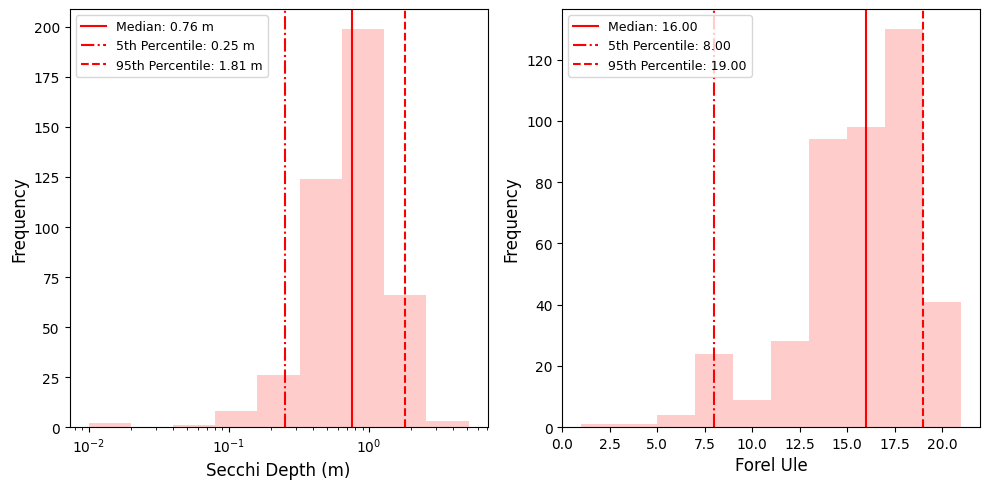

In [6]:
##Set figure up
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))
fig.patch.set_facecolor('White')

## Secchi 
logbins = np.logspace(np.log10(np.min(Secchi)),np.log10(np.max(Secchi)),10)
im1 = ax1.hist(Secchi, bins=logbins,  color = 'r', alpha=0.2)
ax1.set_ylabel('Frequency', fontsize=12) 
ax1.set_xlabel('Secchi Depth (m)', fontsize=12)
# Add median and percentile lines to Secchi plot
secchi_median = np.median(Secchi)
secchi_5th = np.percentile(Secchi, 5)
secchi_95th = np.percentile(Secchi, 95)
ax1.axvline(secchi_median, color='r', linestyle='-', label=f'Median: {secchi_median:.2f} m')
ax1.axvline(secchi_5th, color='r', linestyle='-.', label=f'5th Percentile: {secchi_5th:.2f} m')
ax1.axvline(secchi_95th, color='r', linestyle='--', label=f'95th Percentile: {secchi_95th:.2f} m')
ax1.semilogx()
ax1.legend(loc='upper left', fontsize=9)

## FU 
im2 = ax2.hist(FU, color = 'r', alpha=0.2)
ax2.set_ylabel('Frequency', fontsize=12) 
ax2.set_xlabel('Forel Ule', fontsize=12) 
# Add median and percentile lines to Fu plot
FU_median = np.median(FU)
FU_5th = np.percentile(FU, 5)
FU_95th = np.percentile(FU, 95)
ax2.axvline(FU_median, color='r', linestyle='-', label=f'Median: {FU_median:.2f}')
ax2.axvline(FU_5th, color='r', linestyle='-.', label=f'5th Percentile: {FU_5th:.2f}')
ax2.axvline(FU_95th, color='r', linestyle='--', label=f'95th Percentile: {FU_95th:.2f}')
ax2.legend(loc='upper left', fontsize=9)

plt.tight_layout()
plt.show() 

## STEP 7: Secchi depth vrs Forel Ule

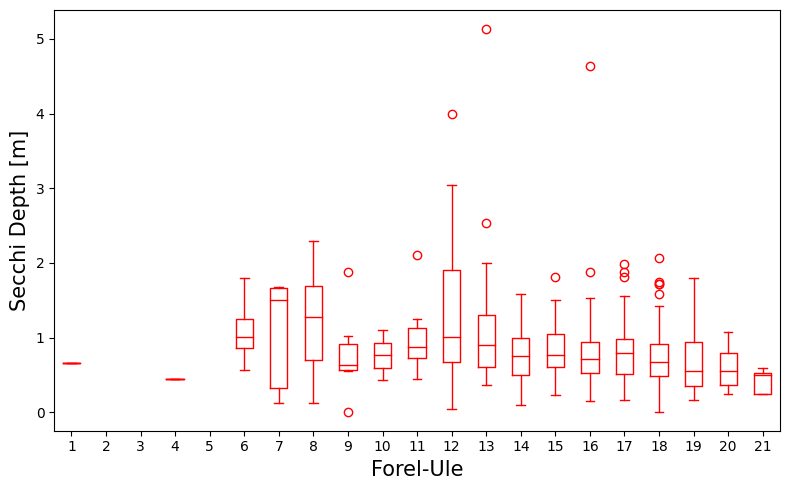

In [7]:
## Bin Secchi data into FU levels
asd = np.where(FU == 1)
YY1 = Secchi[asd]
asd = np.where(FU == 2)
YY2 = Secchi[asd]
asd = np.where(FU == 3)
YY3 = Secchi[asd]
asd = np.where(FU == 4)
YY4 = Secchi[asd]
asd = np.where(FU == 5)
YY5 = Secchi[asd]
asd = np.where(FU == 6)
YY6 = Secchi[asd]
asd = np.where(FU == 7)
YY7 = Secchi[asd]
asd = np.where(FU == 8)
YY8 = Secchi[asd]
asd = np.where(FU == 9)
YY9 = Secchi[asd]
asd = np.where(FU == 10)
YY10 = Secchi[asd]
asd = np.where(FU == 11)
YY11 = Secchi[asd]
asd = np.where(FU == 12)
YY12 = Secchi[asd]
asd = np.where(FU == 13)
YY13 = Secchi[asd]
asd = np.where(FU == 14)
YY14 = Secchi[asd]
asd = np.where(FU == 15)
YY15 = Secchi[asd]
asd = np.where(FU == 16)
YY16 = Secchi[asd]
asd = np.where(FU == 17)
YY17 = Secchi[asd]
asd = np.where(FU == 18)
YY18 = Secchi[asd]
asd = np.where(FU == 19)
YY19 = Secchi[asd]
asd = np.where(FU == 20)
YY20 = Secchi[asd]
asd = np.where(FU == 21)
YY21 = Secchi[asd]

##Set figure up
fig, (ax1) = plt.subplots(1,1, figsize=(8,5))
##Produce a box plot
ax1.boxplot([YY1,YY2,YY3,YY4,YY5,YY6,YY7,YY8,YY9,YY10,YY11,YY12,YY13,YY14,YY15,YY16,YY17,YY18,YY19,YY20,YY21], \
            positions=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21], \
            boxprops=dict(color='r'),\
            capprops=dict(color='r'),\
            whiskerprops=dict(color='r'),\
            flierprops=dict(color='r', markeredgecolor='r'),\
            medianprops=dict(color='r'),\
            showfliers=True)
ax1.set_ylabel('Secchi Depth [m]', fontsize = 15) 
ax1.set_xlabel('Forel-Ule', fontsize = 15)
plt.tight_layout()
plt.show()

## STEP 8: Plot maps of area well sampled: Charleston

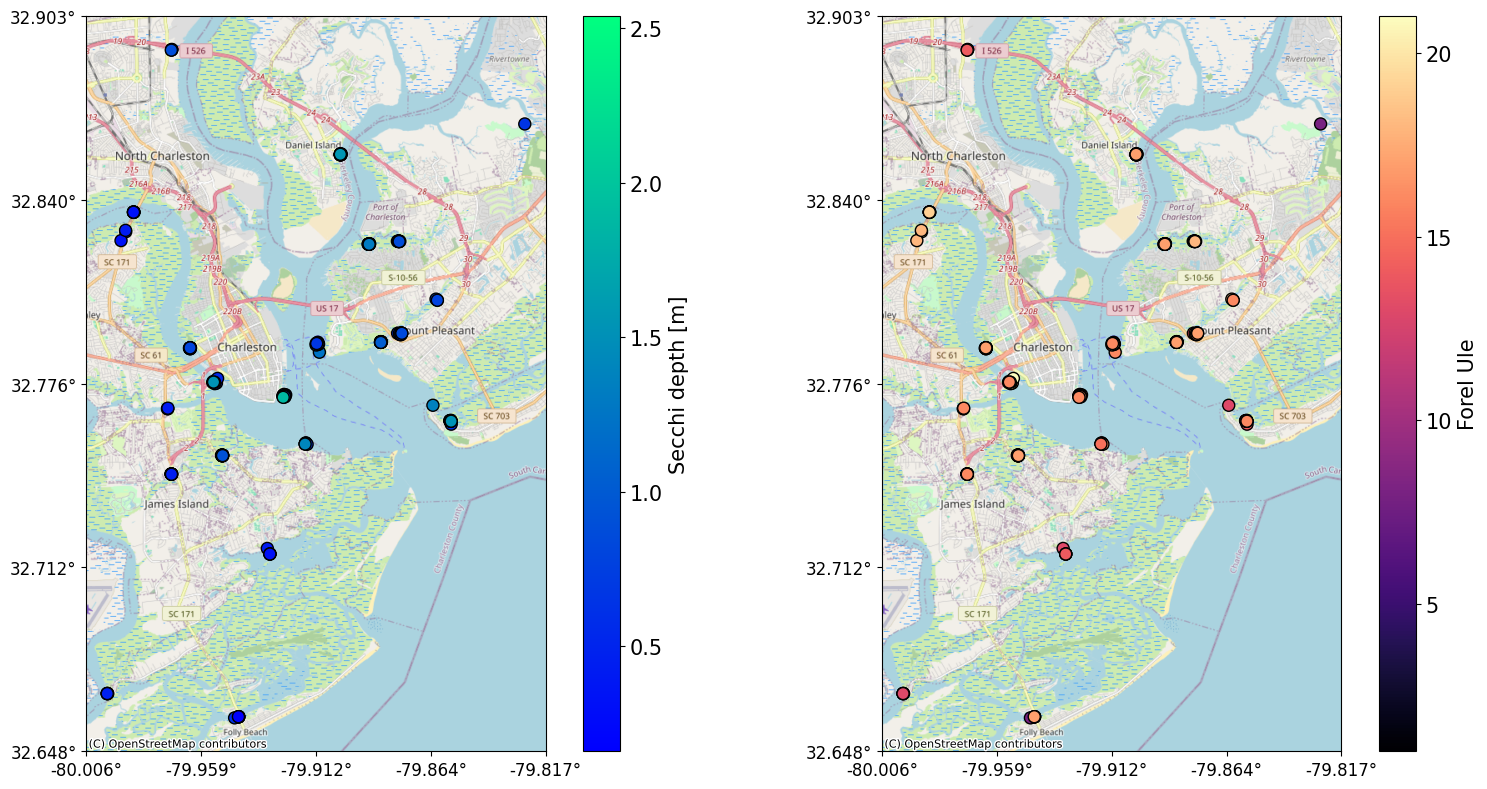

In [8]:
#Hone in of Charleston region 
Max_lon    = -79.807153
Min_lon    = -80.061398
Max_lat    = 32.941844
Min_lat    = 32.617400

#Extract data from region and rename
ASD = np.where(Lat >= Min_lat)
Lat1 = Lat[ASD]
Lon1 = Lon[ASD]
FU1  = FU[ASD]
Secchi1  = Secchi[ASD]
ASD = np.where(Lat1 <= Max_lat)
Lat1 = Lat1[ASD]
Lon1 = Lon1[ASD]
FU1  = FU1[ASD]
Secchi1  = Secchi1[ASD]
ASD = np.where(Lon1 >= Min_lon)
Lat1 = Lat1[ASD]
Lon1 = Lon1[ASD]
FU1  = FU1[ASD]
Secchi1  = Secchi1[ASD]
ASD = np.where(Lon1 <= Max_lon)
Lat1 = Lat1[ASD]
Lon1 = Lon1[ASD]
FU1  = FU1[ASD]
Secchi1  = Secchi1[ASD]

# Create a transformer to convert from WGS84 (EPSG:4326) to Web Mercator (EPSG:3857)
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)

# Create transformers to convert back from Web Mercator (EPSG:3857) to WGS84 (EPSG:4326)
transformer_to_lonlat = Transformer.from_crs("EPSG:3857", "EPSG:4326", always_xy=True)

# Convert coordinates from lat/lon to Web Mercator
x, y = transformer.transform(Lon1, Lat1)  # Ensure these are NumPy arrays or lists

# Define figure and axis
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16, 8))

# Secchi Depth
# Scatter plot for station locations (now using converted coordinates)
im1 = ax1.scatter(x, y, c = Secchi1, s=75, edgecolors='k', linewidths=1, 
                  label="Secchi depth", marker='o', cmap=mpl.cm.winter)
# Add OpenStreetMap basemap (now correctly projected)
ctx.add_basemap(ax1, source=ctx.providers.OpenStreetMap.Mapnik)
# Adjust plot settings
ax1.tick_params(axis='x', labelsize=12)
ax1.tick_params(axis='y', labelsize=12)
# Set custom tick locations (fewer ticks)
num_ticks = 5  # Adjust the number of ticks as needed
ax1.set_xticks(np.linspace(ax1.get_xlim()[0], ax1.get_xlim()[1], num_ticks))
ax1.set_yticks(np.linspace(ax1.get_ylim()[0], ax1.get_ylim()[1], num_ticks))
# Set major ticks format for Longitude (X-axis)
ax1.xaxis.set_major_formatter(mticker.FuncFormatter(merc_to_lonlat))
# Set major ticks format for Latitude (Y-axis)
ax1.yaxis.set_major_formatter(mticker.FuncFormatter(merc_to_latlon))
##Add colourbar
cbar1 = fig.colorbar(im1, ax=ax1)
cbar1.ax.locator_params(nbins=5)
cbar1.set_label("Secchi depth [m]", size = 15)
cbar1.ax.tick_params(labelsize = 15)

# Forel Ule 
# Scatter plot for station locations (now using converted coordinates)
im2 = ax2.scatter(x, y, c = FU1, s=75, edgecolors='k', linewidths=1, 
                  label="Forel Ule", marker='o', cmap=mpl.cm.magma)
# Add OpenStreetMap basemap (now correctly projected)
ctx.add_basemap(ax2, source=ctx.providers.OpenStreetMap.Mapnik)
# Adjust plot settings
ax2.tick_params(axis='x', labelsize=12)
ax2.tick_params(axis='y', labelsize=12)
# Set custom tick locations (fewer ticks)
num_ticks = 5  # Adjust the number of ticks as needed
ax2.set_xticks(np.linspace(ax1.get_xlim()[0], ax1.get_xlim()[1], num_ticks))
ax2.set_yticks(np.linspace(ax1.get_ylim()[0], ax1.get_ylim()[1], num_ticks))
# Set major ticks format for Longitude (X-axis)
ax2.xaxis.set_major_formatter(mticker.FuncFormatter(merc_to_lonlat))
# Set major ticks format for Latitude (Y-axis)
ax2.yaxis.set_major_formatter(mticker.FuncFormatter(merc_to_latlon))
##Add colourbar
cbar2 = fig.colorbar(im2, ax=ax2)
cbar2.ax.locator_params(nbins=5)
cbar2.set_label("Forel Ule", size = 15)
cbar2.ax.tick_params(labelsize = 15)

# Make layout nice
plt.tight_layout()
plt.show()

## STEP 9: Plot maps of area well sampled: Wilmington

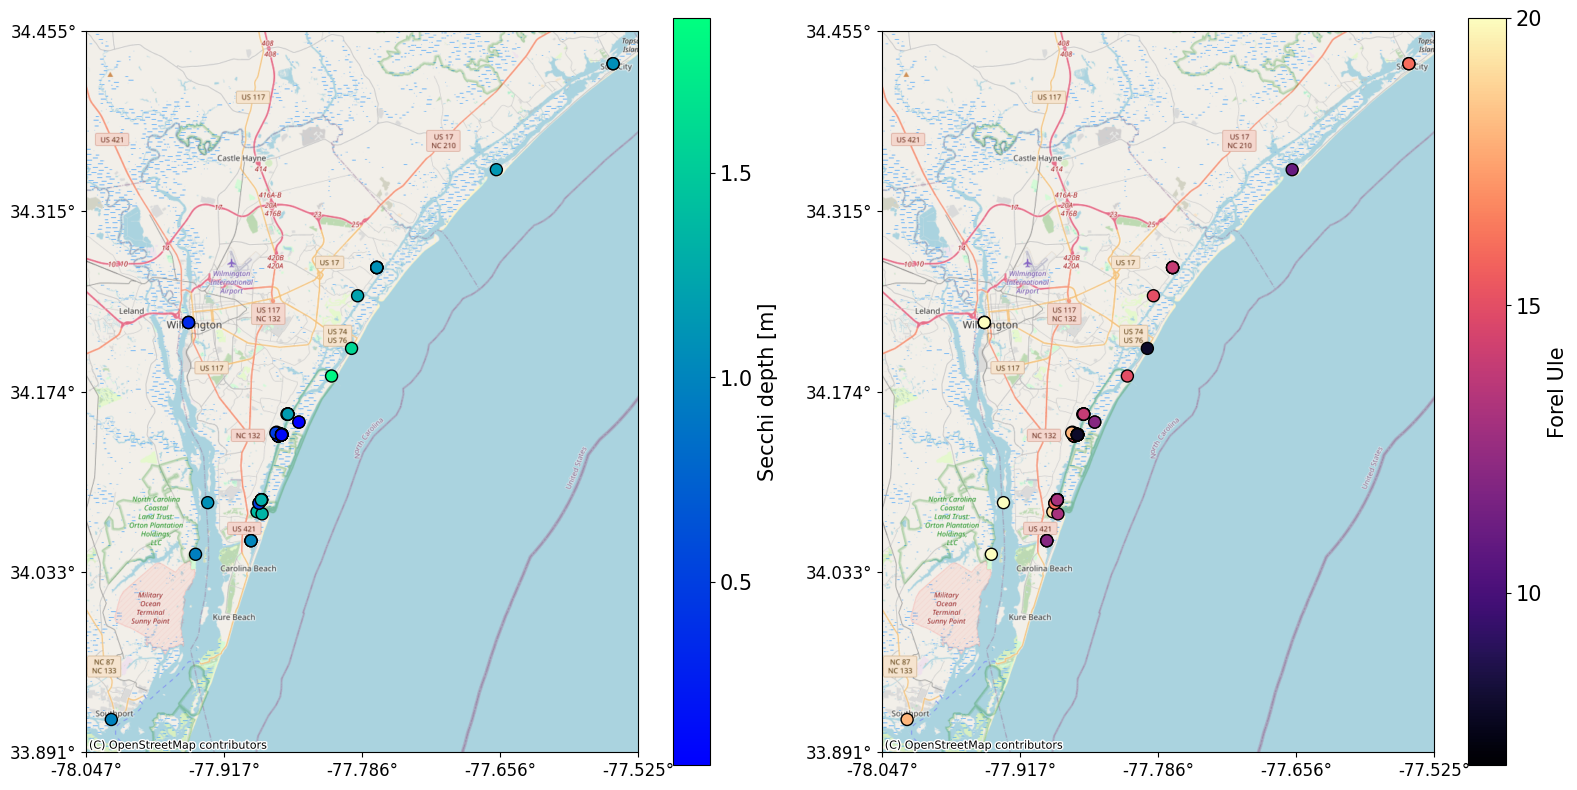

In [9]:
#Hone in of Wilmington region 
Max_lon    = -77.509438
Min_lon    = -78.071489
Max_lat    = 34.442026
Min_lat    = 33.893217

#Extract data from tregion and rename
ASD = np.where(Lat >= Min_lat)
Lat1 = Lat[ASD]
Lon1 = Lon[ASD]
FU1  = FU[ASD]
Secchi1  = Secchi[ASD]
ASD = np.where(Lat1 <= Max_lat)
Lat1 = Lat1[ASD]
Lon1 = Lon1[ASD]
FU1  = FU1[ASD]
Secchi1  = Secchi1[ASD]
ASD = np.where(Lon1 >= Min_lon)
Lat1 = Lat1[ASD]
Lon1 = Lon1[ASD]
FU1  = FU1[ASD]
Secchi1  = Secchi1[ASD]
ASD = np.where(Lon1 <= Max_lon)
Lat1 = Lat1[ASD]
Lon1 = Lon1[ASD]
FU1  = FU1[ASD]
Secchi1  = Secchi1[ASD]

# Create a transformer to convert from WGS84 (EPSG:4326) to Web Mercator (EPSG:3857)
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)


# Create transformers to convert back from Web Mercator (EPSG:3857) to WGS84 (EPSG:4326)
transformer_to_lonlat = Transformer.from_crs("EPSG:3857", "EPSG:4326", always_xy=True)

# Convert coordinates from lat/lon to Web Mercator
x, y = transformer.transform(Lon1, Lat1)  # Ensure these are NumPy arrays or lists

# Define figure and axis
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16, 8))

# Secchi Depth
# Scatter plot for station locations (now using converted coordinates)
im1 = ax1.scatter(x, y, c = Secchi1, s=75, edgecolors='k', linewidths=1, 
                  label="Secchi depth", marker='o', cmap=mpl.cm.winter)
# Add OpenStreetMap basemap (now correctly projected)
ctx.add_basemap(ax1, source=ctx.providers.OpenStreetMap.Mapnik)
# Adjust plot settings
ax1.tick_params(axis='x', labelsize=12)
ax1.tick_params(axis='y', labelsize=12)
# Set custom tick locations (fewer ticks)
num_ticks = 5  # Adjust the number of ticks as needed
ax1.set_xticks(np.linspace(ax1.get_xlim()[0], ax1.get_xlim()[1], num_ticks))
ax1.set_yticks(np.linspace(ax1.get_ylim()[0], ax1.get_ylim()[1], num_ticks))
# Set major ticks format for Longitude (X-axis)
ax1.xaxis.set_major_formatter(mticker.FuncFormatter(merc_to_lonlat))
# Set major ticks format for Latitude (Y-axis)
ax1.yaxis.set_major_formatter(mticker.FuncFormatter(merc_to_latlon))
##Add colourbar
cbar1 = fig.colorbar(im1, ax=ax1)
cbar1.ax.locator_params(nbins=5)
cbar1.set_label("Secchi depth [m]", size = 15)
cbar1.ax.tick_params(labelsize = 15)

# Forel Ule 
# Scatter plot for station locations (now using converted coordinates)
im2 = ax2.scatter(x, y, c = FU1, s=75, edgecolors='k', linewidths=1, 
                  label="Forel Ule", marker='o', cmap=mpl.cm.magma)
# Add OpenStreetMap basemap (now correctly projected)
ctx.add_basemap(ax2, source=ctx.providers.OpenStreetMap.Mapnik)
# Adjust plot settings
ax2.tick_params(axis='x', labelsize=12)
ax2.tick_params(axis='y', labelsize=12)
# Set custom tick locations (fewer ticks)
num_ticks = 5  # Adjust the number of ticks as needed
ax2.set_xticks(np.linspace(ax1.get_xlim()[0], ax1.get_xlim()[1], num_ticks))
ax2.set_yticks(np.linspace(ax1.get_ylim()[0], ax1.get_ylim()[1], num_ticks))
# Set major ticks format for Longitude (X-axis)
ax2.xaxis.set_major_formatter(mticker.FuncFormatter(merc_to_lonlat))
# Set major ticks format for Latitude (Y-axis)
ax2.yaxis.set_major_formatter(mticker.FuncFormatter(merc_to_latlon))
##Add colourbar
cbar2 = fig.colorbar(im2, ax=ax2)
cbar2.ax.locator_params(nbins=5)
cbar2.set_label("Forel Ule", size = 15)
cbar2.ax.tick_params(labelsize = 15)

# Make layout nice
plt.tight_layout()
plt.show()